In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt


from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import matplotlib.pyplot as plt
import torch
torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


2.3.0
2.3.0


In [2]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")


In [3]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

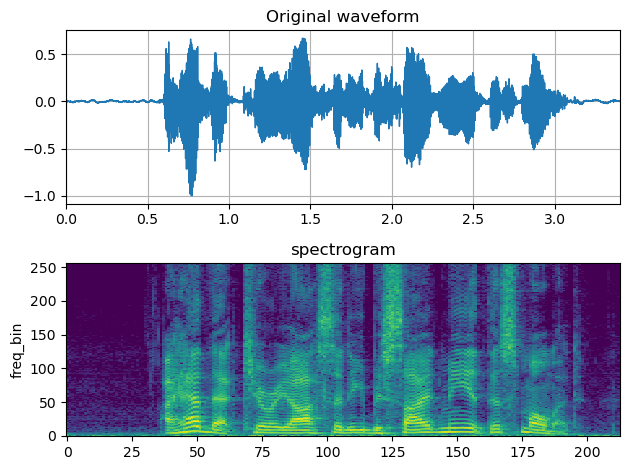

In [4]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [ ]:
n_fft = 512
spectrogram = T.Spectrogram(n_fft=n_fft, power=None)
griffin_lim = T.GriffinLim(n_fft=n_fft,)
inv_spec = T.InverseSpectrogram(n_fft=n_fft)

# Apply the transforms
print(SPEECH_WAVEFORM.shape)
spec = spectrogram(SPEECH_WAVEFORM)
# print(spec)
spec = spec.requires_grad_()
print(spec.shape)

mag = torch.abs(spec)
log_mag = torch.log(mag + 1e-9)

phase = torch.angle(spec)

from torchvision.transforms import Resize, InterpolationMode

size = max(mag.shape)
resize = Resize(size,interpolation=InterpolationMode.NEAREST_EXACT)
reverse_resize = Resize(size = mag.shape[1:],interpolation=InterpolationMode.NEAREST_EXACT)

#reshape and then reverse resize
print(log_mag.shape)
mag = reverse_resize(resize(mag.unsqueeze(0))).squeeze(0)
print(log_mag.shape)

reconstructed_waveform = inv_spec(mag * torch.exp(1j * phase))
# reconstructed_waveform = griffin_lim(spec)


print(reconstructed_waveform.shape)

err = torch.mean((SPEECH_WAVEFORM[...,:reconstructed_waveform.shape[-1]] - reconstructed_waveform)**2)
print(err)
err.backward()
# print(spec.grad)

torch.Size([1, 54400])
torch.Size([1, 257, 213])
torch.Size([1, 257, 213])
torch.Size([1, 257, 213])
torch.Size([1, 54272])
tensor(0.0061, grad_fn=<MeanBackward0>)


In [29]:
54400//256

212

In [30]:
spectrogram.shape

AttributeError: 'Spectrogram' object has no attribute 'shape'

In [31]:
from torchvision.transforms import Resize

In [32]:
x = torch.rand((3,224,224)).requires_grad_()
print(x.shape)

y = Resize((112,112))(x)
print(y.shape)
print(y)

torch.Size([3, 224, 224])
torch.Size([3, 112, 112])
tensor([[[0.5654, 0.6056, 0.4472,  ..., 0.5748, 0.4436, 0.5494],
         [0.6120, 0.5862, 0.6743,  ..., 0.6037, 0.3746, 0.5223],
         [0.5764, 0.4537, 0.5270,  ..., 0.3500, 0.4742, 0.5820],
         ...,
         [0.4224, 0.3980, 0.5263,  ..., 0.4115, 0.4889, 0.5063],
         [0.5730, 0.5346, 0.3836,  ..., 0.4559, 0.6008, 0.2967],
         [0.4771, 0.4914, 0.2262,  ..., 0.5627, 0.6114, 0.5599]],

        [[0.5634, 0.5512, 0.5666,  ..., 0.3324, 0.6166, 0.5977],
         [0.4988, 0.5528, 0.4924,  ..., 0.3630, 0.4770, 0.4774],
         [0.5781, 0.4997, 0.5701,  ..., 0.3894, 0.3575, 0.4069],
         ...,
         [0.5729, 0.4938, 0.5793,  ..., 0.3067, 0.5429, 0.4144],
         [0.4575, 0.4655, 0.5104,  ..., 0.5492, 0.4581, 0.3663],
         [0.4154, 0.4593, 0.4603,  ..., 0.4280, 0.6103, 0.5135]],

        [[0.6584, 0.5500, 0.4232,  ..., 0.5985, 0.6234, 0.6894],
         [0.5094, 0.3862, 0.4659,  ..., 0.5784, 0.4599, 0.4063],
      

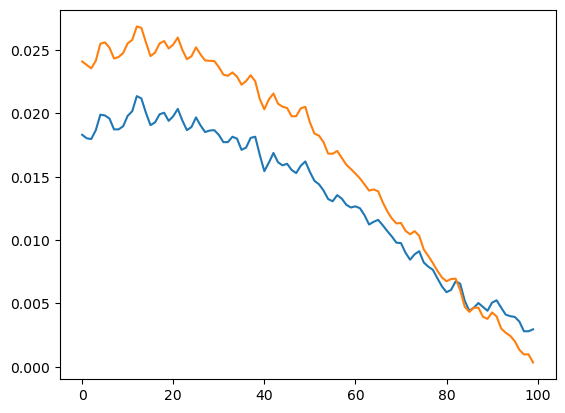

In [33]:
plt.plot(SPEECH_WAVEFORM[0][:100].numpy(), label="Original")
plt.plot(reconstructed_waveform[0][:100].detach().numpy(), label="Reconstructed")
# plt.plot(spec.grad[0].numpy().flatten(), label="Gradient")

In [6]:
from wavelets_pytorch.transform import WaveletTransformTorch   # PyTorch version

dt = 1/SAMPLE_RATE         # sampling frequency
dj = 0.125           # "wavelet width" (default value)

wa_torch = WaveletTransformTorch(dt, dj, cuda=True)

# Perform transform
wa = wa_torch.cwt(SPEECH_WAVEFORM.numpy())

In [13]:
SPEECH_WAVEFORM.shape

torch.Size([1, 54400])

In [18]:
librosa.power_to_db(wa).shape

/tmp/ipykernel_73331/1910420705.py:1: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.power_to_db(wa).shape


(119, 54400)

/tmp/ipykernel_73331/2604122981.py:30: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


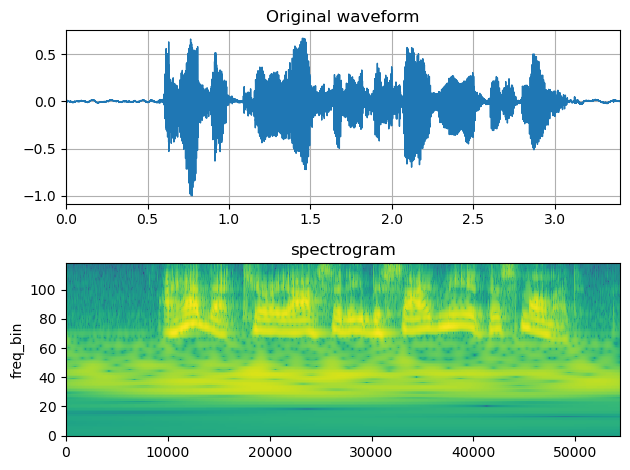

In [20]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(wa[::-1], title="spectrogram", ax=axs[1])
fig.tight_layout()

(1000,)
(22,)
(22,)
(38,)
(69,)
(131,)
(255,)
(503,)


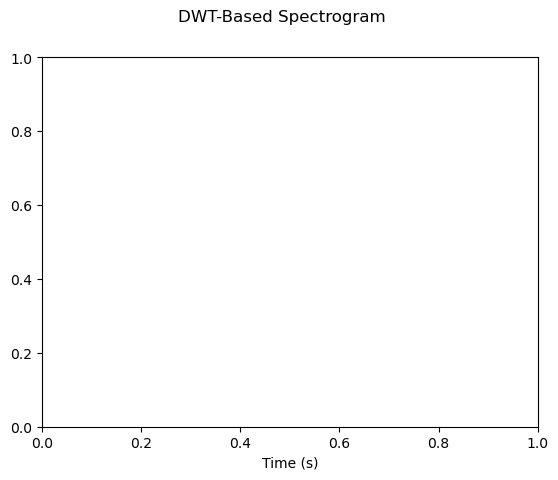

In [28]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Simulated EMG signal
fs = 1000  # Sampling frequency in Hz
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 150 * t)  # Example EMG-like signal
print(signal.shape)
# Perform a 6-level DWT decomposition using Daubechies-4 wavelet
wavelet = 'db4'
coeffs = pywt.wavedec(signal, wavelet, level=6)

for coeff in coeffs:
    print(coeff.shape)
# plt.imshow(coeffs, aspect='auto', cmap='jet')
# # Convert to a spectrogram-like visualization
# plt.figure(figsize=(8, 6))
# for i, coeff in enumerate(coeffs[1:]):  # Skip approximation coefficients
#     plt.subplot(len(coeffs)-1, 1, i+1)
#     plt.imshow(np.abs(coeff).reshape(1, -1), aspect='auto', cmap='jet', extent=[0, t[-1], 0, 1])
#     plt.ylabel(f'Level {i+1}')

plt.xlabel('Time (s)')
plt.suptitle('DWT-Based Spectrogram')
plt.show()

In [23]:
! pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.8 MB/s eta 0:00:00a 0:00:01


/home/lawrence/miniconda3/envs/emg2qwerty/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


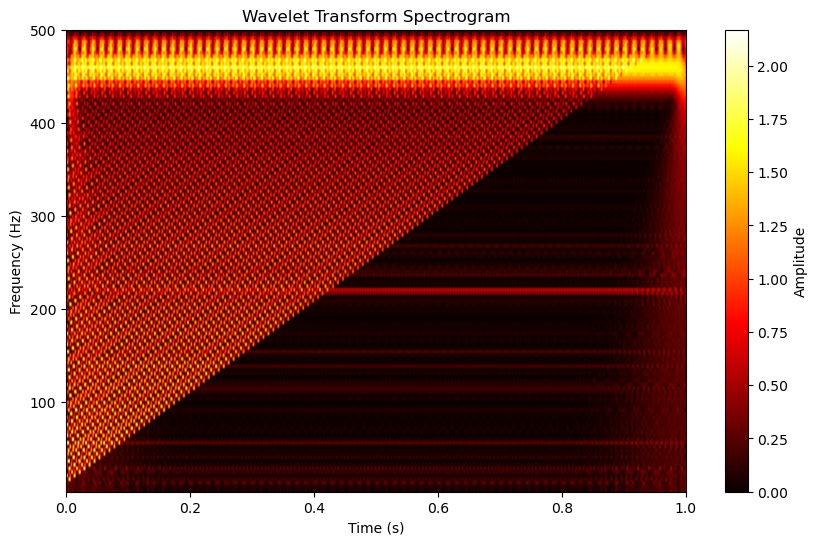

In [29]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Generate a sample signal
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)

# Perform Discrete Wavelet Transform (DWT)
wavelet = 'cmor'  # Choose a continuous wavelet (or discrete like 'db4')
coeffs, freqs = pywt.cwt(signal, scales=np.arange(1, 128), wavelet=wavelet, sampling_period=1/fs)

# Convert to a Spectrogram-like image
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, 1, freqs[-1], freqs[0]], cmap='hot')
plt.colorbar(label="Amplitude")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Wavelet Transform Spectrogram")
plt.show()

In [1]:
import torch.nn as nn

In [3]:
attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)

In [5]:
attention.state_dict().keys()

odict_keys(['in_proj_weight', 'in_proj_bias', 'out_proj.weight', 'out_proj.bias'])

In [7]:
for key in attention.state_dict().keys():
    print(key)
    print(attention.state_dict()[key].shape)

in_proj_weight
torch.Size([1536, 512])
in_proj_bias
torch.Size([1536])
out_proj.weight
torch.Size([512, 512])
out_proj.bias
torch.Size([512])
